**Sumber : https://www.kaggle.com/santoshd3/bank-customers**

# Importing Modules and Files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Modules needed
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np, math, warnings
from collections import Counter
from scipy import stats as ss
from sklearn.utils import resample
from scipy.stats import skew, iqr
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.utils import resample

# Adjust cell width to enhance data display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Ignores warning
warnings.filterwarnings("ignore")

# Read file and drop unnecessary columns
data = pd.read_csv("/content/drive/My Drive/data/bank_dataset.csv").drop(["RowNumber", "CustomerId", "Surname"], 1)

print("Data structure :")
display(data.head(1))
print("Data length : ", len(data), " rows")

Data structure :


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


Data length :  10000  rows


**Headers Info**

These informations are not obtained from the data author since he gives no info at all. So, from logical reasoning and other notebooks, I try to understand and define it by myself as following:
- CreditScore : Customers score based on their credit activities with the bank (increment in credit transaction means increment in credit score)
- Geography : Country of origin
- Gender : Gender
- Age : Age
- Tenure : The last customer's credit tenure period in months (0 means no credit transaction at the given time)
- Balance : Current customer's balance when the data is obtained
- NumOfProducts : Number of bank's products the customers have (products is assumed as types of account, fixed deposits, car insurance , home loan, etc)
- HasCrCard : Etiher the customers have credit card or not
- IsActiveMember : This variable is believed as customer's activeness indicator based on their activeness to join / involved in bank's program / promotion.
- EstimatedSalary : Estimated customer's salary at the given time
- Exited : Either customer is staying or not

# Business Problem

Churned customers isn't a stand alone problem. It always bring bigger problem when it comes to bank competition and survival. As we know, bank lives by controlling, managing, and regulating its customers money in such a way to gain profit by applying interest to them. So customers savings and transactions are the most important things to keep the wheel spinning. Hence, exiting customers will definitely affect the cycle. Not only that, there's also a high chance that they move to other competitors. Besides profit loss, it can affect the bank's sentiments too. Exiting customers must have a logical reasoning behind their decision, either it's a financial problem (e.g. bank doesn't give them profitable interest), managerial problem (e.g. difficulty in proposing loan), or even personal problem (with the bank's representative, e.g. Relationship Officer or Customer Service). Thus, this problem must be seriously handled and even if it can, must be prevented.

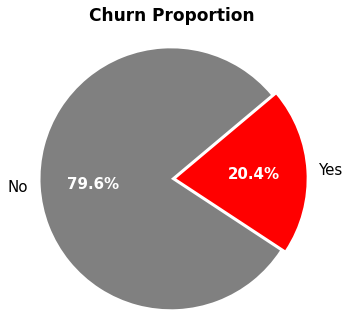

In [3]:
# Visualizing churn proportion
# Maka itu, subplots harus digunakan untuk dapat memberi warna, ukuran, dan style yang berbeda terhadap keduanya. 

fig, churnMember = plt.subplots() #subplots is used to set color, size, and style for percentage and label respectively
percentage, label, chart = churnMember.pie(
        data.groupby("Exited").count()["CreditScore"], explode = (.01, .05),
        labels = ["No", "Yes"], autopct = "%1.1f%%", startangle = 40,
        colors = ["grey", "red"], textprops = {"size" : 15,"color" : "black"},
        radius = 1.5)

plt.setp(chart, **{"color" : "white", "weight" :"bold", "fontsize" : 15})
plt.title("Churn Proportion", fontdict = {'fontsize': 17,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.2)

plt.show()

Looking at the data, we have 20.4% customers whose exited. It seems like not a big number. But, if we put the percentage into the above context we will understand why 20.4% is an important alert.

# Goals

The goals are simply and solely to find correlation between customer's variables and their exiting decision. Those analysis will help us to understand the context better. Also we will build a model to predict either they will exit or not. In the end, the deployed system (later) will help the bank to maintain its remaining customers. It will also help Relationship Officer division (or similar) to understand their customers better, so expected approach can be conducted. The bank also can find this useful to review and re - train their Customer Service behaviour and communication approach (applying special approach to customers whose predicted to most likely churn).

# Variables Overview

In [4]:
# Data description
dataDesc = []
for x in data.columns:
    dataDesc.append([
        x,
        data[x].dtypes,
        data[x].isnull().sum(),
        round((((data[x].isnull().sum()) / (len(data))) * 100), 2),
        len(data[x].unique()),
        data[x].drop_duplicates().sample(2).values
    ])

print("Variables description :")
display(pd.DataFrame(data = dataDesc, columns = [
    "Columns Name",
    "Data Type",
    "NULL",
    "NULL Percentage",
    "Unique",
    "Unique Samples"
]))

Variables description :


,Columns Name,Data Type,NULL,NULL Percentage,Unique,Unique Samples
0,CreditScore,int64,0,0.0,460,"[513, 475]"
1,Geography,object,0,0.0,3,"[France, Germany]"
2,Gender,object,0,0.0,2,"[Female, Male]"
3,Age,int64,0,0.0,70,"[38, 48]"
4,Tenure,int64,0,0.0,11,"[0, 10]"
5,Balance,float64,0,0.0,6382,"[163708.58, 137727.34]"
6,NumOfProducts,int64,0,0.0,4,"[4, 1]"
7,HasCrCard,int64,0,0.0,2,"[0, 1]"
8,IsActiveMember,int64,0,0.0,2,"[0, 1]"
9,EstimatedSalary,float64,0,0.0,9999,"[136934.91, 101039.53]"


The data looks perfect with no missing values. Also there's no column to be transformed right now besides **Age** (further encoding for string columns is needed when processing the model).

In [5]:
# Adding ageRange column to better visualize and classify the data.
# Range is set to 5 years because I think it's the most appropriate number.
# Take an example of 8 or 10 years. Customer whose 18 years old will join the 18 - 26 years old or 18 - 28 years old category.
# This can lead to data misunderstanding and conclusion fallacy since 18 years old customer (still in college) doesn't have fixed income yet like 25 - 28 years old customer did.
# On the other hand if we lower the range (e.g. 3 years old), then it'll be hard to visualize the data since there will be a lot of categories.
# This ageRange is used to understand customer's common behaviour better.
ageRange, ar = [], range(data["Age"].min(), data["Age"].max(), 5)

for a in data["Age"]:
    count = -1
    for i, r in enumerate(ar):
        count += 1
        try:
            if (r + count) <= a <= (ar[i + 1] + count):
                ageRange.append(f"{r + count} - {ar[i + 1] + count}")
                break
            elif (ar[i + 1] + count + 1) <= a <= (ar[i + 2] + count + 1):
                ageRange.append(f"{ar[i + 1] + count + 1} - {ar[i + 2] + count + 1}")
                break
        except:
            ageRange.append(f"> {r + 1}")
            break
                
data["ageRange"] = ageRange

In [6]:
# New structure
print("New data structure :")
display(data.head(1))

New data structure :


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,ageRange
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1,42 - 47


# Distribution, Outliers, and Correlation

In [7]:
# Defines formulas to check association
def correlation_ratio(categories, measurement):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measure = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measure)
        y_avg_array[i] = np.average(cat_measure)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurement, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurences
        p_y = y_counter[xy[1]] / total_occurences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else :
        return (s_x - s_xy) / s_x

In [8]:
# Quantitative report
print("Data quantitative report :")
display(data.describe())

Data quantitative report :


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Age** and **Balance** seem to have outliers based on their Q3 - max value gap. Meanwhile other variables looks fine. But, for further checking we will look deeper to each features distribution and also their correlation / association with target (price range).

In [9]:
# Adding temporary column for checking correlation ratio value
intGeo = []
for x in data["Geography"]:
    if x == "France":
        intGeo.append(0)
    elif x == "Spain":
        intGeo.append(1)
    else:
        intGeo.append(2)
        
data["intGeo"] = intGeo

intGender = []
for x in data["Gender"]:
    if x == "Male":
        intGender.append(0)
    else:
        intGender.append(1)

data["intGender"] = intGender

In [10]:
# Correlation / association of each column
temp = []
for i in data.drop(["Geography", "Gender", "ageRange", "Exited"], 1).columns:
    if len(data[i].unique()) <= 3:
        temp.append({"Column" : i, "Value" : round(theils_u(data[i], data["Exited"]), 5), "" : "Theils U"})
    else:
        temp.append({"Column" : i, "Value" : round(correlation_ratio(data["Exited"], data[i]), 5), "" : "Correlation Ratio"})
    
print("Correlation / association value of each column :")
tempDF = pd.DataFrame(temp).sort_values("Value", ascending = False).reset_index().drop("index", 1)
tempDF["Column"] = tempDF["Column"].apply(lambda x : x.replace("intGender", "Gender").replace("intGeo", "Geography"))
display(tempDF)

Correlation / association value of each column :


,Column,Value,
0,Age,0.28532,Correlation Ratio
1,Balance,0.11853,Correlation Ratio
2,NumOfProducts,0.04782,Correlation Ratio
3,CreditScore,0.02709,Correlation Ratio
4,IsActiveMember,0.01774,Theils U
5,Tenure,0.01400,Correlation Ratio
6,Geography,0.01349,Theils U
7,EstimatedSalary,0.01210,Correlation Ratio
8,Gender,0.00820,Theils U
9,HasCrCard,0.00004,Theils U


Since **HasCrCard** has no association with churn decision, we will eliminte them and focus ony on the top 9. Actually, **Gender** has no association too. But based on personal preferences and knowledge, we keep it to see how it contributes to analysis. This such **feature selection** will help us to determine which variables that have best impact on churn decision and thus maximize the model and its process. 

In [11]:
# New structure
print("New structure :")
data.drop(["HasCrCard"], 1, inplace = True)
data = data[["Geography", "Age", "Gender", "intGender", "ageRange", "Balance", "EstimatedSalary", "CreditScore", "Tenure", "NumOfProducts", "IsActiveMember", "Exited"]]
display(data.head(1))

New structure :


,Geography,Age,Gender,intGender,ageRange,Balance,EstimatedSalary,CreditScore,Tenure,NumOfProducts,IsActiveMember,Exited
0,France,42,Female,1,42 - 47,0.0,101348.88,619,2,1,1,1


In [12]:
# Checking anomaly
print("Column non - binary that have 0 as value :\n")
for i in data.drop("Exited", 1).columns:
    if len(data[i].unique()) > 3:
        if 0 in data[i].unique():
            print(i)

Column non - binary that have 0 as value :

Balance
Tenure


0 as value in **Tenure** columns is still make sense since it indicates absence of customer's current credit transaction. However, 0 as value in **Balance** doesn't quite make sense on some cases. It is a common knowledge that bank have set a minimum value for customer's account, so even if customers withdrawn all of their money, the system force them to leave the minimum value.

But, there's also some banks that allows their customers to empty their account. One of them is this bank we're working on, so we assumed this 0 value in **Balance** isn't an anomaly. Thus we **keep** them.

## Customers Age


Skewness value :  1.01


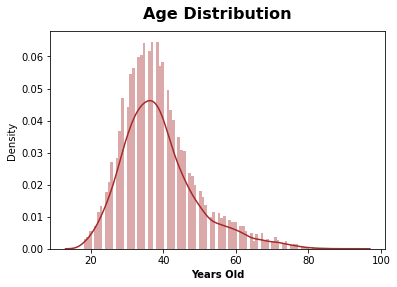

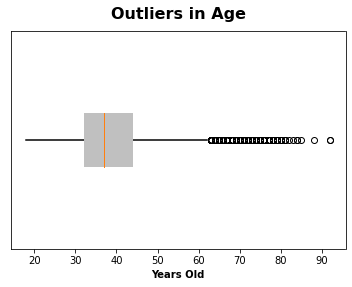

In [13]:
# Distribution
print("\nSkewness value : ", round(skew(data["Age"]), 2))

sns.distplot(data["Age"], bins = 100, color = "brown")
plt.title(
        "Age Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Years Old",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["Age"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Age",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Years Old",
    fontdict = {"weight" : "bold"
    })

plt.show()

Age has a positive highly skewed distribution (right skewed). It means customers are centralized in middle age (32 - 44 years old). Meanwhile, old customers are very rare. 

In [14]:
# Showing outliers
upperFence = np.quantile(data["Age"], .75) + (1.5 * iqr(data["Age"]))
print("Age upperFence : ", int(upperFence), "years old")
print("Number of outliers : ", len (data[data["Age"] > upperFence]), "data")
print("Outliers sample :")
display(data[data["Age"] > upperFence].head(10))

Age upperFence :  62 years old
Number of outliers :  359 data
Outliers sample :


,Geography,Age,Gender,intGender,ageRange,Balance,EstimatedSalary,CreditScore,Tenure,NumOfProducts,IsActiveMember,Exited
58,Spain,66,Female,1,66 - 71,0.00,1643.11,511,4,1,0,1
85,Spain,75,Female,1,72 - 77,0.00,114675.75,652,10,2,1,0
104,Spain,65,Female,1,60 - 65,0.00,177655.68,670,1,1,1,1
158,France,73,Female,1,72 - 77,97259.25,104719.66,646,6,1,1,0
181,France,65,Male,0,60 - 65,0.00,48071.61,510,2,2,1,0
230,France,72,Male,0,72 - 77,0.00,111981.19,673,1,2,1,0
234,France,67,Female,1,66 - 71,113978.97,93146.11,585,5,2,1,0
243,Germany,67,Male,0,66 - 71,117411.60,45071.09,659,6,1,1,1
252,France,79,Female,1,78 - 83,0.00,170968.99,681,0,2,1,0
310,France,80,Female,1,78 - 83,0.00,188603.07,652,4,2,1,0


There's nothing wrong with the outliers. Beside, our goal is to predict all of the bank's customer, so no need to limit them by age. Hence we **keep** them.

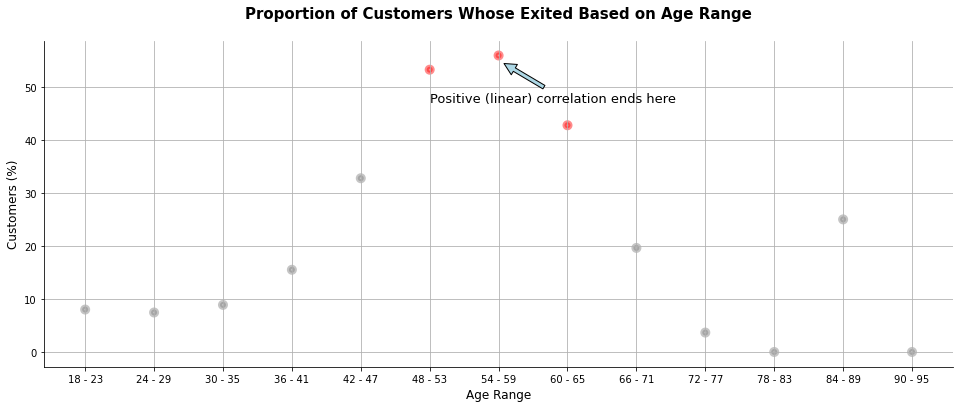

In [15]:
# Menampilkan bukti lanjutan korelasi antar variabel dengan scatter plot.
# Oleh karena distribusi umur tidak normal, maka kita tidak bisa langsung menggunakan jumlah per kelompok sebagai perbandingan. 
# Untuk mensiasatinya, maka digunakan presentase per kelompok per keputusan (pindah / tidak pindah).

# Showing how ageRange speaks about churn decision
# We use proportion instead of total because of non - normal distribution age had
ageProp = pd.crosstab(data["ageRange"], data["Exited"], normalize = "index") * 100

# Using subplots to remove top and right frame
fig, churnAge = plt.subplots(figsize = (16.3, 6))
churnAge.spines["right"].set_visible(False)
churnAge.spines["top"].set_visible(False)
plt.grid(True)
plt.scatter(ageProp.index, ageProp[1],
            color = ["grey", "grey", "grey", "grey", "grey", "red", "red", "red", "grey", "grey", "grey", "grey", "grey"],
            linewidths = 4, alpha = 0.45)
plt.annotate("Positive (linear) correlation ends here",
            xy = ("54 - 59", 55),
            xytext = ("48 - 53", 46.5),
            fontsize = 13,
            arrowprops = {"facecolor" : "lightblue", "shrink" : 0.1},
            horizontalalignment = "left", verticalalignment = 'bottom')
plt.title("Proportion of Customers Whose Exited Based on Age Range", size = 15, weight = "bold", y = 1.05)
plt.xlabel("Age Range", size = 12)
plt.ylabel("Customers (%)", size = 12)
plt.show()

The highest proportion of churn appears on 48 - 65 years old customers with its peak on **54 - 59 years old**. Age range also turns out has a linear pattern, but **not fully linear**. The churn proportion decreasing quite significant entering 60 - 65 years old customers. This means, linear pattern (the older the customer is then chance for him to churn increases) only applied on **18 - 59** years old customers. Pattern becomes unpredictable outside that range. It does decrease from 60 - 65 to 78 - 83 years old, but it suddenly increases entering 84 - 89 years old.

But again, we can't just focus on 18 - 59 years old customers, although they have a beautiful pattern. We still include the elder since our goal **has no limitation in age**.

## Geography

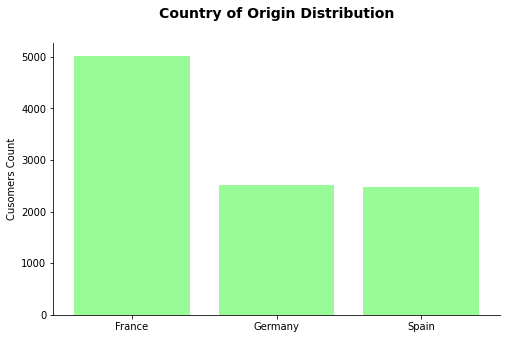

In [16]:
# Distribution
fig, churnCountry= plt.subplots(figsize = (8, 5))
temp = data.groupby("Geography").count()[["Age"]]
churnCountry.spines["top"].set_visible(False)
churnCountry.spines["right"].set_visible(False)
plt.bar(temp.index, temp["Age"],
       color = "palegreen",
       linewidth = 1)

plt.title("Country of Origin Distribution", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.ylabel("Cusomers Count")

plt.show()

France is the most valuable country because it has the highest customers number. Meanwhile Germany and Spain shares quite same value. But how about it's association with churn decision?

In [17]:
# Customers churn based on country
temp = round((pd.crosstab(data["Geography"], data["Exited"], normalize = "index") * 100), 2).rename(
    columns = {
        0 : "No (%)", 1 : "Yes (%)"
    }
    )
temp.columns.name = ""
temp.index.name = "Country of Origin"

print("Churn Percentage per country of origin :")
display(temp)

Churn Percentage per country of origin :


,No (%),Yes (%)
Country of Origin,,
France,83.85,16.15
Germany,67.56,32.44
Spain,83.33,16.67


Turns out that France is not only valuable, but also their customers are very loyal. It has the highest percentage of retained customers and the lowest percentage of churned. On the other hand, Germany has the highest rate of churned customers.

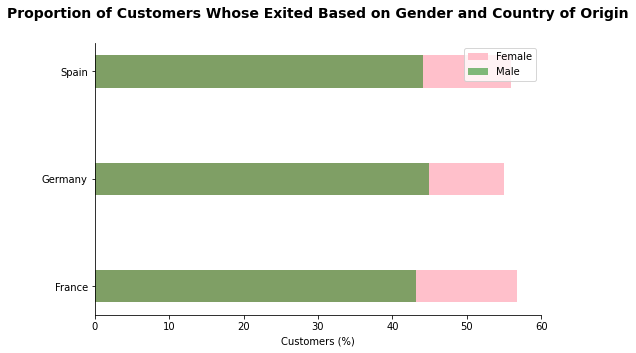

In [18]:
# Customers gender whose churned based on country
# Using proportion because it has non - normal distribution
churnSegAge = pd.crosstab(data[data["Exited"] == 1]["Geography"],
                 data[data["Exited"] == 1]["Gender"], normalize = "index") * 100

fig, churnCountry = plt.subplots(figsize = (8, 5))
churnCountry.spines["top"].set_visible(False)
churnCountry.spines["right"].set_visible(False)
plt.barh(churnSegAge.index, churnSegAge["Female"],
       color = "pink",
       height = 0.3,
       linewidth = 1)

plt.barh(churnSegAge.index, churnSegAge["Male"],
       color = "green",
       height = 0.3,
       alpha = 0.5,
       linewidth = 1)
plt.legend(("Female", "Male"))
plt.xlim(0, 60)
plt.title("Proportion of Customers Whose Exited Based on Gender and Country of Origin", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.xlabel("Customers (%)")

plt.show()

We have an interesting fact here. No matter what country does the customers come from, it is always female whose churn more than male. It's consistently stands above 43%. It is believed because of bad relation and experience with their Relationship Officer or Customer Service. Female tend to have more soft and sensitive behaviour. So, just a slight bad experience could ruin their day and emotion. Hence further review is needed for Relationship Officer and Customer Service team.

## Balance


Skewness value :  -0.14


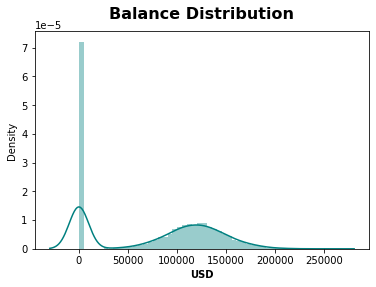

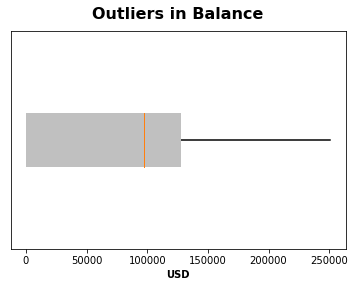

In [19]:
# Distribution
print("\nSkewness value : ", round(skew(data["Balance"]), 2))

sns.distplot(data["Balance"], bins = 50, color = "teal")
plt.title(
        "Balance Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "USD",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["Balance"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Balance",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "USD",
    fontdict = {"weight" : "bold"
    })

plt.show()

Even tough many customers has 0 USD, balance distribution is still quite normal based on its skewness value. Hence there's no outliers found. No lower fence whisker at the boxplot means Q1 equal to minimum value.

Regardless of its distribution, it's quite suspicious that why customers left no balance in their account. At least there's three assumptions to answer the question:

**First**, this bank account isn't their primary bank account. It's possible that they join this bank just for one - time transaction only, e.g. special offer or big promotion by the bank.

**Second**, customers do empty their account by normal transaction.

**Third**, customers purposely empty their account because of churn decision. When they decided to exit, and maybe join another bank, they **transfer the whole account value to their new account**.

In [20]:
# Proportion of 0 USD customers and >0 USD customers
Perbandingan jumlah nasabah dengan saldo 0 USD dan di atas 0 USD
fig, balanceProp = plt.subplots()
percentage, label, chart = balanceProp.pie(
        [(len(data[data["Balance"] == 0]) / len(data)) * 100,
        (len(data[data["Balance"] != 0]) / len(data)) * 100],
        explode = (.01, .05), labels = ["0 USD", "> 0 USD"], autopct = "%1.1f%%",
        startangle = 90, colors = ["darkblue", "grey"], textprops = {"size" : 13,"color" : "black"},
        radius = 1.2)

plt.setp(chart, **{"color" : "white", "weight" :"bold", "fontsize" : 14})
plt.title("Balance Proportion", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.05)

plt.show()

SyntaxError: ignored

36,2% isn't a small proportion. We have to look deeper to know if there's hidden correlation between 0 USD customers with churn decision.

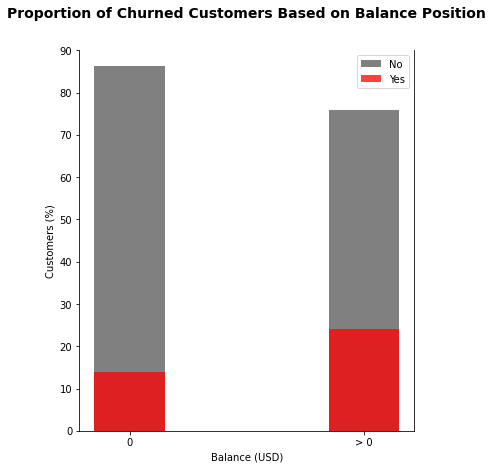

In [21]:
# Labeling each row according to their balance position
data["balanceLabel"] = data["Balance"].apply(lambda x : "0" if x == 0 else "> 0")

balanceProp = round((pd.crosstab(data["balanceLabel"], data["Exited"], normalize = "index") * 100), 2)

# Memakai subplots karena ingin membuang frame bagian atas
fig, churnBalance = plt.subplots(figsize = (6,7))
churnBalance.spines["top"].set_visible(False)
plt.bar(balanceProp.index, balanceProp[0],
       color = "grey",
       width = 0.3,
       linewidth = 1)

plt.bar(balanceProp.index, balanceProp[1],
       color = "red",
       alpha = 0.75,
       width = 0.3,
       linewidth = 1)
plt.legend(("No", "Yes"))
plt.ylim(0, 90)
plt.title("Proportion of Churned Customers Based on Balance Position", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.xlabel("Balance (USD)")
plt.ylabel("Customers (%)")

plt.show()

Graph shown above broke one of our assumptions that customers with 0 USD in balance are customers whose wanted to exit from the bank by emptying their whole balance. On the contrary, they tend to be loyal. Thus, we focus on customers whose balance is not 0 USD.

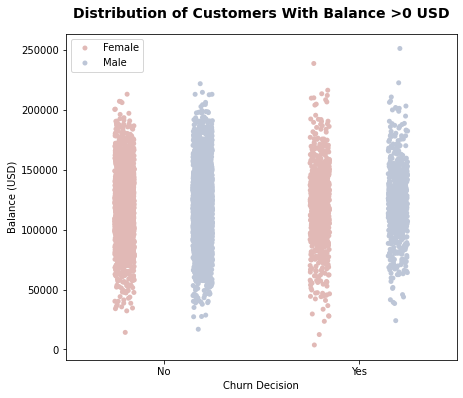

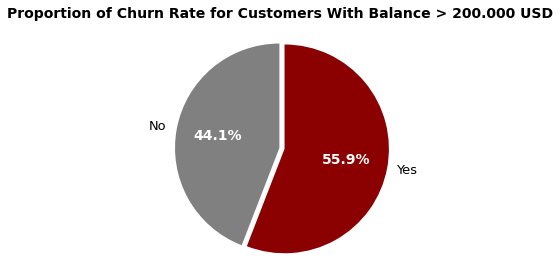

In [22]:
# Visualizing distribution of customers with balance above 0 USD
fig, balanceMoreZero = plt.subplots(figsize = (7, 6))
sns.stripplot(data[data["balanceLabel"].str.contains("> 0")]["Exited"], data[data["balanceLabel"].str.contains("> 0")]["Balance"],
              hue = data[data["balanceLabel"].str.contains("> 0")]["Gender"],
              palette = "vlag_r", jitter = True, dodge = True)
plt.xlabel("Churn Decision")
plt.ylabel("Balance (USD)")
balanceMoreZero.set_xticklabels(["No", "Yes"])
plt.title("Distribution of Customers With Balance >0 USD", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.legend(("Female", "Male"))
plt.show()
print("\n")

# Percentage of churn for customers with balance above 200.000 USD
fig, priorMember = plt.subplots()
percentage, label, chart = priorMember.pie(
        [(data[data["Balance"] > 200000].groupby("Exited").count()["Gender"][0] / data[data["Balance"] > 200000].groupby("Exited").count().sum()[0]) * 100,
        (data[data["Balance"] > 200000].groupby("Exited").count()["Gender"][1] / data[data["Balance"] > 200000].groupby("Exited").count().sum()[0]) * 100],
        explode = (.01, .05), labels = ["No", "Yes"], autopct = "%1.1f%%",
        startangle = 90, colors = ["grey", "darkred"], textprops = {"size" : 13,"color" : "black"},
        radius = 1.2)

plt.setp(chart, **{"color" : "white", "weight" :"bold", "fontsize" : 14})
plt.title("Proportion of Churn Rate for Customers With Balance > 200.000 USD", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)

plt.show()

Either it is churned or not, the graph shows centralization on the range of 90.000 - 160.000 USD. But, customers whose staying appears more sporadic than than churned customers.

Turns out the from the churned customers, we have most likely priority / special customers who has above 200.000 USD on their balance. These are customers that play vital role in the bank's cycle because of their great amount (bigger interest for bank, higher probability to apply loan / credit, etc). We just can't conclude that increment in balance followed by increment of churn propability. But, we found **small correlation** for those who have above 200.000 USD on their balance (see pie chart). On the other hand, gender seems not playing its role in this situation.

We have two assumptions why this priority / special customers churned:
- Difficulty on applying credit / loan (too much proses / bureaucracy).
- The bank can't offer competing / profitable intereset compared to its competitor.

In [23]:
# Country of origin for priority and non - priority customers whose churned

countryPrioChurn = custData[custData["Balance"] > 200000][custData[custData["Balance"] > 200000]["Exited"].astype(str).str.contains("1")].groupby("Geography").count()["Gender"]
countryPrio = custData[custData["Balance"] > 200000].groupby("Geography").count()[["Gender"]].rename(columns = {
    "Gender" : "Total Customers"
}).sort_values("Total Customers", ascending = False)
countryPrio["Churn"] = countryPrioChurn
countryPrio["Churn"] = countryPrio["Churn"].fillna(0).astype(int)
countryPrio["Churn (%)"] = [(countryPrio["Churn"][i] / countryPrio["Total Customers"][i]) * 100 for i in countryPrio.index]

print("Percentage of priority customers whose churned:")
display(countryPrio.drop("Churn", 1))

ordMemberChurn = custData[custData["Balance"] < 200000][custData[custData["Balance"] < 200000]["Exited"].astype(str).str.contains("1")].groupby("Geography").count()["Gender"]
ordMember = custData[custData["Balance"] < 200000].groupby("Geography")[["Gender"]].count().sort_values("Gender", ascending = False).rename(columns = {
    "Gender" : "Total Customers"
})
ordMember["Churn"] = ordMemberChurn
ordMember["Churn (%)"] = [round(((ordMember["Churn"][i] / ordMember["Total Customers"][i]) * 100), 1) for i in ordMember.index]

print("\n\nPercentage of non - priority customers whose churned :")
display(ordMember.drop("Churn", 1))

NameError: ignored

Spain has the highest rate of churned priority customers. Meanwile, for non - priority customers, Germany is the highest. This means something wrong with the bank's representative in Spain or even with their local policy.

## Customer Activeness

In [24]:
activeMember = round((pd.crosstab(custData["IsActiveMember"], custData["Exited"], normalize = "index") * 100), 2)
activeMember

NameError: ignored

In [ ]:
# Showing association
activeMember = round((pd.crosstab(custData["IsActiveMember"], custData["Exited"], normalize = "index") * 100), 2)

# Menggunakan subplots karena ingin mengurangi jumlah xticks dan mengganti xticklabels
fig, activeMemberChurn = plt.subplots(figsize = (7, 7))
plt.bar(activeMember.index-.06, activeMember[0],
       color = "black",
       alpha = 0.1,
       width = .20,
       linewidth = 0.25)

plt.bar(activeMember.index, activeMember[1],
       color = "cyan",
       width = .20,
       alpha = 0.75,
       linewidth = 0.25)
plt.locator_params(axis = "x", nbins = 2)
activeMemberChurn.set_xticklabels(["", "Not Active", "Active"])
activeMemberChurn.spines["top"].set_visible(False)
plt.xlabel("Customer Activeness Status")
plt.ylabel("Customers (%)")
plt.ylim(0, 90)
plt.legend(("Staying", "Churned"))
plt.title("Proportion of Churned Customers Based on Their Activeness", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.05)

plt.show()

This variables looks normal dan rational if we compare with the reality. Basically, customers whose active in bank program / promotion won't be that easy to churn because they got many benefit. Customers whose not active on the other hand have higher churn possibility because of low loyalty and "relation" to the bank.

## Credit Score


Skewness value :  -0.07


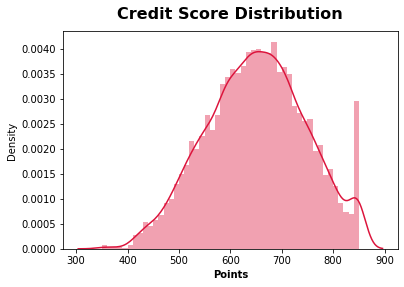

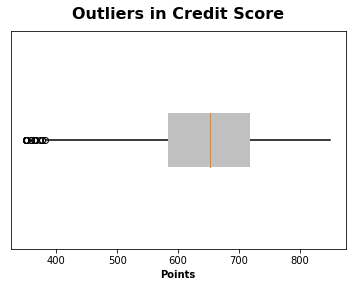

In [25]:
# Distribution
print("\nSkewness value : ", round(skew(data["CreditScore"]), 2))

sns.distplot(data["CreditScore"], bins = 50, color = "crimson")
plt.title(
        "Credit Score Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Points",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["CreditScore"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Credit Score",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Points",
    fontdict = {"weight" : "bold"
    })

plt.show()

Credit score has a normal distribution, but a slight centralization on its higher value. This means customers with middle - high credit score is much more than those with low score. Because of that, we found outliers.

In [26]:
# Showing outliers
lowerFence = np.quantile(data["CreditScore"], .25) - (1.5 * iqr(data["CreditScore"]))
print("Credit Score upperFence : ", int(lowerFence), "points")
print("Number of outliers : ", len (data[data["CreditScore"] < lowerFence]), "data")
print("Outliers sample :")
display(data[data["CreditScore"] < lowerFence])

Credit Score upperFence :  383 points
Number of outliers :  15 data
Outliers sample :


,Geography,Age,Gender,intGender,ageRange,Balance,EstimatedSalary,CreditScore,Tenure,NumOfProducts,IsActiveMember,Exited,balanceLabel
7,Germany,29,Female,1,24 - 29,115046.74,119346.88,376,4,4,0,1,> 0
942,France,46,Female,1,42 - 47,0.00,157333.69,376,6,1,0,1,0
1193,Spain,28,Female,1,24 - 29,146098.43,100615.14,363,6,3,0,1,> 0
1405,France,44,Female,1,42 - 47,128747.69,146955.71,359,6,1,0,1,> 0
1631,Spain,54,Male,0,54 - 59,152677.48,191973.49,350,1,1,1,1,> 0
1838,Germany,39,Male,0,36 - 41,109733.20,123602.11,350,0,2,0,1,> 0
1962,Spain,52,Female,1,48 - 53,143542.36,141959.11,358,8,3,0,1,> 0
2473,Germany,57,Female,1,54 - 59,163146.46,169621.69,351,4,1,0,1,> 0
2579,Germany,30,Male,0,30 - 35,127760.07,81537.85,365,0,1,0,1,> 0
8154,Spain,42,Male,0,42 - 47,93608.28,168816.73,367,6,1,0,1,> 0


These outliers mean nothing because its very low number. Thus we do nothing about it.

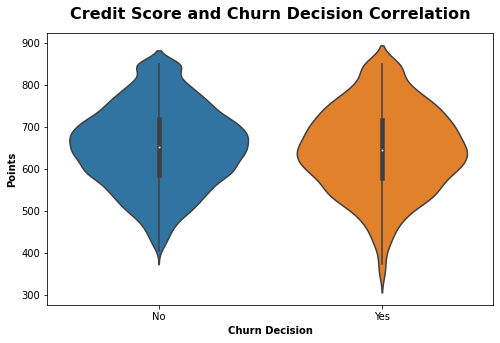


Credit score average per decision :


,Credit Score (Points)
No,651.853196
Yes,645.351497


In [27]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["Exited"], data["CreditScore"])
plt.title(
        "Credit Score and Churn Decision Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Points",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Churn Decision",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0, 1), ("No", "Yes"))

plt.show()

temp = data.groupby("Exited").mean().rename(columns = {"CreditScore" : "Credit Score (Points)"})[["Credit Score (Points)"]]
temp.index.name = "Churn Decision"
temp.index = ["No", "Yes"]
print("\nCredit score average per decision :")
display(temp)

There's no significant impact from credit score.

# Modelling

## Base Model

Base Model is used to see potential algorithms. Later, only those potentials will be tuned to maximazie the model.

### Preparation

In [28]:
# Using One Hot Encoding to encode "Geography"
data = pd.get_dummies(data = data, columns = ["Geography"])

For **Gender**, we don't use One Hot Encoding since it's a binary. Besides, we already defined it as **intGender**.

In [31]:
# Data Proportion
print("Target proportion")
temp = (pd.crosstab(data["Exited"], columns = "count", normalize = "columns") * 100).rename(columns = {"count" : "Percentage"})
temp.columns.name = ""
temp.index.name = "Churn Decision"
display(temp)

Target proportion


,Percentage
Churn Decision,
0,79.63
1,20.37


Because the data is quite imbalanced, we use random over sampling technique to handle this.

In [38]:
# Random Over Sampling
churnNo, churnYes = data[data["Exited"] == 0], data[data["Exited"] == 1]
churnYesOS = resample(churnYes, replace = True, n_samples = len(churnNo), random_state = 7)

dataOS = pd.concat([churnNo, churnYesOS])

print("Oversampled data :")
temp = (pd.crosstab(dataOS["Exited"], columns = "count", normalize = "columns") * 100).rename(columns = {"count" : "Percentage"})
temp.columns.name = ""
temp.index.name = "Churn Decision"
display(temp)

Oversampled data :


,Percentage
Churn Decision,
0,50.0
1,50.0


In [40]:
# Splitting Data
X = data.drop(["Gender", "ageRange", "balanceLabel", "Exited"], 1)
y = data["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 7)

In [41]:
# Algorithms
# Random Forest Classifier
RanFor = RandomForestClassifier().fit(X_train, y_train)
RanForPredTrain = RanFor.predict(X_train)
RanForPredTest = RanFor.predict(X_test)

# Support Vector Machine Classifier
SVM = SVC().fit(X_train, y_train)
SVMPredTrain = SVM.predict(X_train)
SVMPredTest = SVM.predict(X_test)

# Extreme Gradient Boosting Classifier
XGB = XGBClassifier().fit(X_train, y_train)
XGBPredTrain = XGB.predict(X_train)
XGBPredTest = XGB.predict(X_test)

Random Forest Classifier :



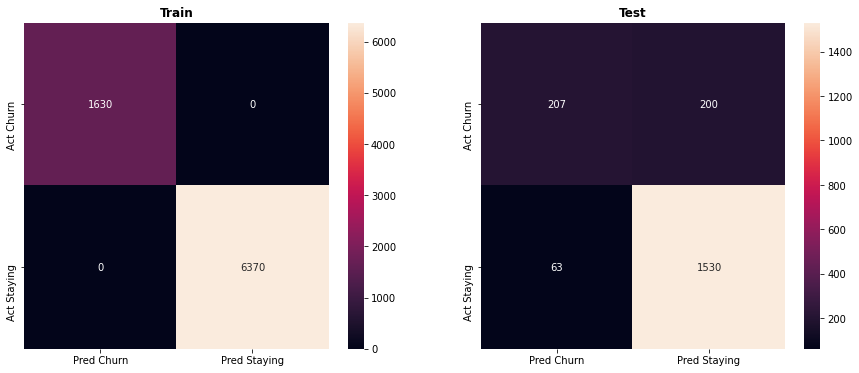


SVM Classifier :



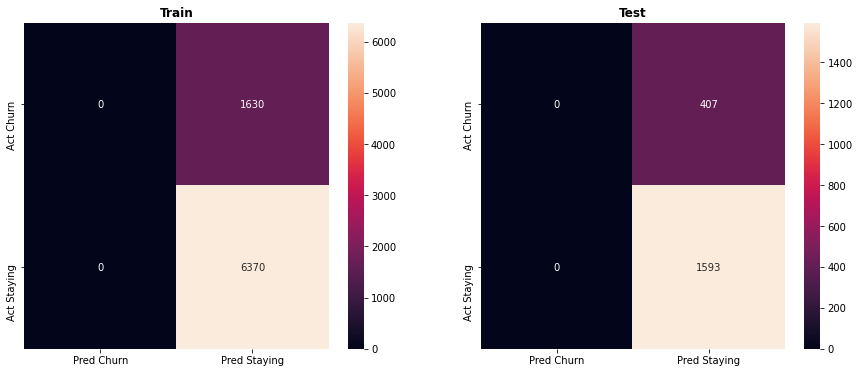


XGB Classifier :



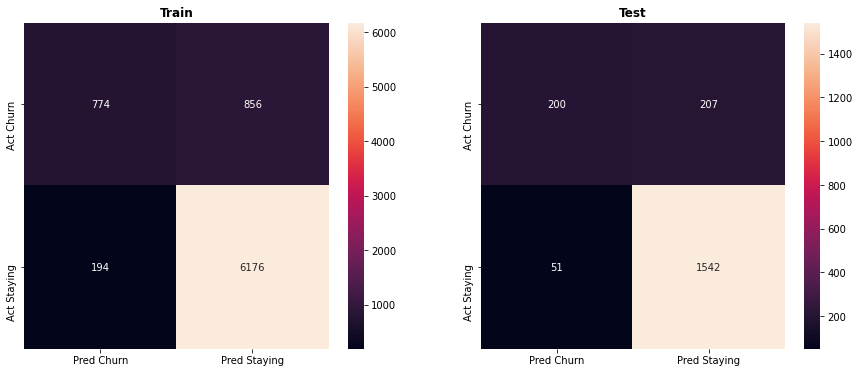

In [61]:
# Evaluation Metrics
# Random Forest Classifier
temptrain = confusion_matrix(y_train, RanForPredTrain, labels = [1, 0])
temptrain = pd.DataFrame(temptrain, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
temptest = confusion_matrix(y_test, RanForPredTest, labels = [1, 0])
temptest = pd.DataFrame(temptest, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
print("Random Forest Classifier :\n")
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(temptrain, annot = True, fmt = 'g')
plt.title("Train", fontdict = {"weight" : "bold"})
plt.subplot(1, 2, 2)
sns.heatmap(temptest, annot = True, fmt = 'g')
plt.title("Test", fontdict = {"weight" : "bold"})
plt.show()

# Support Vector Machine Classifier
temptrain = confusion_matrix(y_train, SVMPredTrain, labels = [1, 0])
temptrain = pd.DataFrame(temptrain, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
temptest = confusion_matrix(y_test, SVMPredTest, labels = [1, 0])
temptest = pd.DataFrame(temptest, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
print("\nSVM Classifier :\n")
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(temptrain, annot = True, fmt = 'g')
plt.title("Train", fontdict = {"weight" : "bold"})
plt.subplot(1, 2, 2)
sns.heatmap(temptest, annot = True, fmt = 'g')
plt.title("Test", fontdict = {"weight" : "bold"})
plt.show()

# Extreme Gradient Boositng Classifier
temptrain = confusion_matrix(y_train, XGBPredTrain, labels = [1, 0])
temptrain = pd.DataFrame(temptrain, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
temptest = confusion_matrix(y_test, XGBPredTest, labels = [1, 0])
temptest = pd.DataFrame(temptest, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
print("\nXGB Classifier :\n")
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(temptrain, annot = True, fmt = 'g')
plt.title("Train", fontdict = {"weight" : "bold"})
plt.subplot(1, 2, 2)
sns.heatmap(temptest, annot = True, fmt = 'g')
plt.title("Test", fontdict = {"weight" : "bold"})
plt.show()

In this context, the most important thing for the machine is it can suppress the error of predicting **churn to staying (False Negative)**. We can't tolerate this error because failing to predict churned customers make the machine useless. Besides, we'll get many loss if this type of error is high. Take an example of customer A whose actually wanted to exit, but the machine tells us he's most likely staying. The bank and its team lose opportunity to retain him. Also dont't forget problems followed by it (as stated in the beggining). So, the FN error is very crucial. Thus, we focus on **recall score**.

On the other hand, **False Positive or error in predicting staying to churn** can be tolerated. Take an example of customer A again. He won't most likely to leave the bank, but the machine tells us he'll exit. There's no loss for the bank at this point. The only effort it spends is contacting, ensuring problem, and fixing the communication approcah for the related customers. It only cost the bank time (and maybe phone bill?), so this error doesn't really matter.

SVM Classifier is the worst model of all. It even fails to predict **all churned customers** in the train data. Meanwhile, the best model is Random Forest Classifier, where its FN score is the lowest. XGB also did quite good in reducing FN score on test data (7 points gap with Random Forest). But, Random Forest still have the best train score of all, even tough it seems **overfit**. To maximize those model, we will perform **hyper parameter tuning**.

## Tuned Model

**Hyper Parameter Tuning**

### Random Forest Classifier

Random Forest doesn't need scaling to maximize its model since it's a tree based algorithm. Hence we jump in to Hyper Parameter Tuning.

In [65]:
RanForTuned = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions = {
        "n_estimators" : [100, 300, 500],
        "max_depth" : [None, 5, 7, 9],
        "min_samples_split" : [5, 15, 25],
        "min_samples_leaf" : [2, 7, 10],
        "max_features" : ["auto", .3, .5],
        "min_impurity_decrease" : [0, 0.5, 0.7]
        }, cv = 3, n_jobs = -1, verbose = 1, scoring = "recall"
    )

RanForTuned.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Recall score for train data :  [0 0 0 ... 0 0 0] 



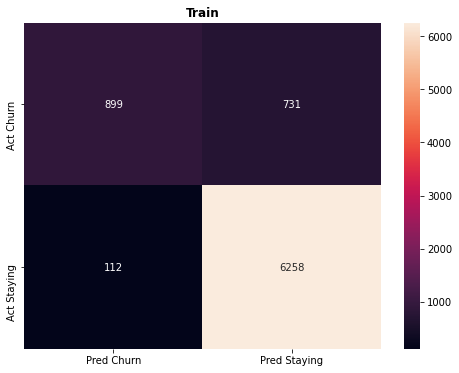


Recall score for test data :  [0 0 0 ... 0 0 0] 



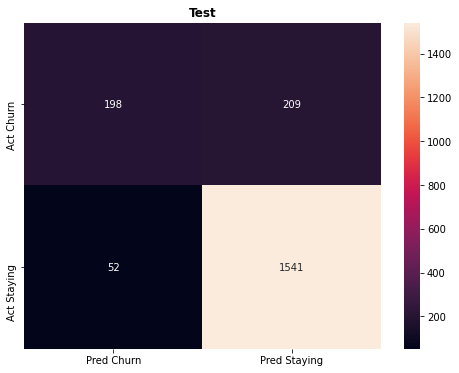

In [67]:
# Evaluation Metrics
bestRanForTuned = RanForTuned.best_estimator_
bestRanForTunedPredTest = bestRanForTuned.predict(X_test)
bestRanForTunedPredTrain = bestRanForTuned.predict(X_train)

print("Recall score for train data : ", recall_score(y_train, bestRanForTunedPredTrain), "\n")
temptrain = confusion_matrix(y_train, bestRanForTunedPredTrain, labels = [1, 0])
temptrain = pd.DataFrame(temptrain, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
plt.figure(figsize = (8, 6))
sns.heatmap(temptrain, annot = True, fmt = 'g')
plt.title("Train", fontdict = {"weight" : "bold"})
plt.show()

print("\nRecall score for test data : ", recall_score(y_test, bestRanForTunedPredTrain), "\n")
temptest = confusion_matrix(y_test, bestRanForTunedPredTest, labels = [1, 0])
temptest = pd.DataFrame(temptest, index = ["Act Churn", "Act Staying"], columns = ["Pred Churn", "Pred Staying"])
plt.figure(figsize = (8, 6))
sns.heatmap(temptest, annot = True, fmt = 'g')
plt.title("Test", fontdict = {"weight" : "bold"})
plt.show()

# Rekomendasi

1. Lakukan *training* dan *screening* terhadap para RO yang menangani nasabah **wanita berusia 48 - 59 tahun**, terlepas dari mana negara asalanya. Besar kemungkinan permasalahan ini akibat buruknya manajemen hubungan mereka dengan nasabah. Opsi lainnya adalah merekrut ataupun menukar RO terkait dengan yang sudah berpengalaman. Divisi lain yang perlu diperbaiki adalah Customer Service. Kami meyakini bahwa buruknya penanganan masalah dan keluhan lewat CS juga turut memberi dampak, mengingat nasabah dalam kelompok ini cenderung lebih perasa.
2. Segera lakukan pendekatan khusus bagi nasabah prioritas (memiliki saldo di atas 200.000 USD) di Perancis dan Spanyol. Dua negara ini adalah sumber utama nasabah prioritas kita. Namun, disarankan agar pengembangan dan perbaikan difokuskan ke Spanyol. Hal ini dikarenakan presentase kepindahannya adalah yang tertinggi. Kami sarankan agar tim analis - bisnis **mengkaji ulang tingkat bunga yang ditwarkan** karena kemungkinan besar terlalu tinggi jika dibandingkan dengan bank swasta / daerah lain di Spanyol dan Perancis. **Penyesuaian dan kompromi dalam memberi pinjaman** pada nasabah prioritas di dua negara ini juga patut menjadi pertimbangan. Pasalnya, nasabah prioritas cenderung memiliki tingkat kredit produktif yang lebih tinggi dibandingkan nasabah biasa.
3. Dalam konteks nasabah biasa (memiliki saldo di bawah 200.000 USD), tidak ditemukan pengaruh khusus dalam variabel data. Namun, yang menarik adalah bahwa Jerman menjadi lumbung terbesar nasabah yang pindah. Ada dua kemungkinan disini: **Pertama**, konteks sosial - budaya - ekonomi Jerman yang belum tim kita mengerti penuh (sehingga diperlukan studi perbandingan lebih lanjut untuk memahaminya) dan **kedua** ada permasalahan sistem internal di Bank Purwad cabang Jerman. Maka itu kami menawarkan **dua solusi**:
    - Segera pahami dan pelajari konteks nasabah di Jerman kemudian bentuk program / manajemen baru yang dikhususkan untuk pasar setempat.
    - Segera investigasi dan perbaiki permasalahan dalam tubuh organisasi Bank Purwad Jerman.